<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219
Primer semestre - 2024

## Taller 7

**Integrante 1:** Jose Manuel Moreno - 201011998

**Integrante 2:** William Ravelo - 201532093


Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

Los datos se encuentran en el siguiente enlace: https://www.dropbox.com/scl/fi/qh6dk5qch11rfuz9hmptm/Data.zip?rlkey=wdteinhhad7s6j5okq0bjosvq&dl=0

NOTA: El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller7.ipynb

## Helpers

In [1]:
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new!
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D #new!
from tensorflow.keras.optimizers import RMSprop # new!

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Metodo para ver ejemplo de imagenes generadas por generador

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.uniform(-1.0, 1.0, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# Primer dataset - Dog

## Cargar set de datos  y visualizar un ejemplo:

In [ ]:
input_images = "dog.npy"
data = np.load(input_images)

In [ ]:
data = data/255

data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]

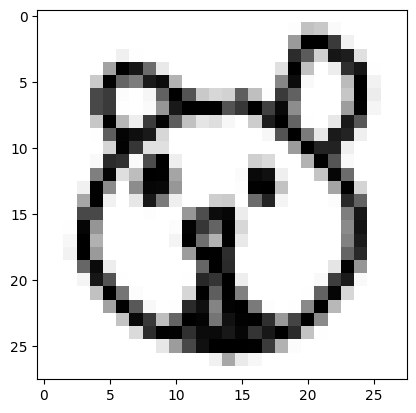

In [ ]:
plt.imshow(data[200,:,:,0], cmap='Greys')

## Construcción de modelo - Imagenes para: DOG

In [ ]:
def build_dog_generator(z_dim):
    model_f = Sequential()

    model.add(Dense(128 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))

    return model

In [ ]:
def build_dog_discriminator(img_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def build_dog_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model

## Construcción del Modelo - DOG:

In [ ]:
# Se escoge un canal y un espacio latente de dimension 100

channels = 1
img_shape = (img_w, img_h, channels)
z_dim = 100

In [ ]:
discriminator = build_dog_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

In [ ]:
generator = build_dog_generator(z_dim)

In [ ]:
gan = build_dog_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       147584    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)      

In [ ]:
noise_vector = np.random.normal(size=(z_dim,1))
noise_image = generator.predict(noise_vector.T)

1/1 [==============================] - 0s 364ms/step


Dimensiones antes de implementar squeeze: (1, 28, 28, 1)
Dimensiones despues de implementar squeeze: (28, 28)




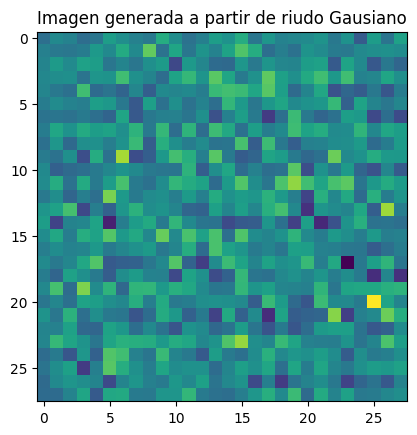

In [ ]:
# Vemos una imagen de ejemplo generada a partir del ruido

print(f'Dimensiones antes de implementar squeeze: {noise_image.shape}')
print(f'Dimensiones despues de implementar squeeze: {noise_image.squeeze().shape}')
print('\n')
plt.imshow(noise_image.squeeze())
plt.title('Imagen generada a partir de ruido Gausiano')
plt.show()

## Train model

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Entrenar discriminator
        # -------------------------
        idx = np.random.randint(0, data.shape[0], batch_size)
        imgs = data[idx]

        z = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim])
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Entrenar generator
        # ---------------------
        z = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim])
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])

            gen_imgs = generator.predict(noise)
            plt.figure(figsize=(1, 1))
            plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
            plt.show()

4/4 [==============================] - 0s 88ms/step
200 [D loss: 0.001617, acc.: 100.00%] [G loss: 6.473994]
1/1 [==============================] - 0s 48ms/step


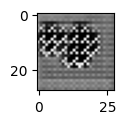

4/4 [==============================] - 0s 64ms/step
400 [D loss: 0.029134, acc.: 99.61%] [G loss: 2.678578]
1/1 [==============================] - 0s 55ms/step


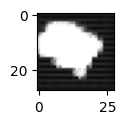

4/4 [==============================] - 0s 84ms/step
600 [D loss: 0.014888, acc.: 100.00%] [G loss: 3.346708]
1/1 [==============================] - 0s 48ms/step


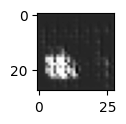

4/4 [==============================] - 0s 64ms/step
800 [D loss: 0.055862, acc.: 98.44%] [G loss: 6.888450]
1/1 [==============================] - 0s 50ms/step


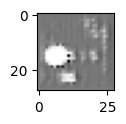

4/4 [==============================] - 0s 89ms/step
1000 [D loss: 0.042950, acc.: 99.61%] [G loss: 3.087767]
1/1 [==============================] - 0s 85ms/step


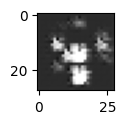

4/4 [==============================] - 0s 62ms/step
1200 [D loss: 0.026228, acc.: 99.22%] [G loss: 3.939492]
1/1 [==============================] - 0s 54ms/step


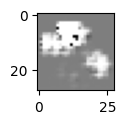

4/4 [==============================] - 0s 65ms/step
1400 [D loss: 0.070748, acc.: 97.66%] [G loss: 2.511590]
1/1 [==============================] - 0s 49ms/step


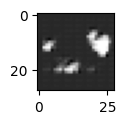

4/4 [==============================] - 0s 59ms/step
1600 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.168160]
1/1 [==============================] - 0s 49ms/step


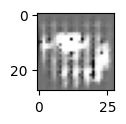

4/4 [==============================] - 0s 67ms/step
1800 [D loss: 0.000845, acc.: 100.00%] [G loss: 3.022586]
1/1 [==============================] - 0s 52ms/step


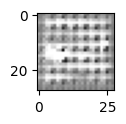

4/4 [==============================] - 0s 67ms/step
2000 [D loss: 0.004330, acc.: 100.00%] [G loss: 1.024660]
1/1 [==============================] - 0s 51ms/step


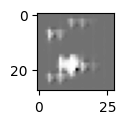

4/4 [==============================] - 0s 63ms/step
2200 [D loss: 0.006094, acc.: 99.61%] [G loss: 6.524112]
1/1 [==============================] - 0s 50ms/step


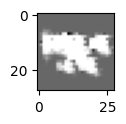

4/4 [==============================] - 0s 69ms/step
2400 [D loss: 0.000000, acc.: 100.00%] [G loss: 9.501608]
1/1 [==============================] - 0s 53ms/step


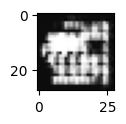

4/4 [==============================] - 0s 63ms/step
2600 [D loss: 0.002771, acc.: 100.00%] [G loss: 7.571963]
1/1 [==============================] - 0s 80ms/step


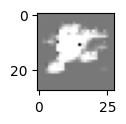

4/4 [==============================] - 0s 70ms/step
2800 [D loss: 0.037526, acc.: 98.44%] [G loss: 1.827375]
1/1 [==============================] - 0s 68ms/step


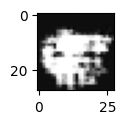

4/4 [==============================] - 0s 65ms/step
3000 [D loss: 0.002210, acc.: 100.00%] [G loss: 0.459653]
1/1 [==============================] - 0s 51ms/step


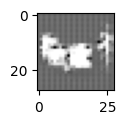

4/4 [==============================] - 0s 62ms/step
3200 [D loss: 0.002540, acc.: 100.00%] [G loss: 0.081070]
1/1 [==============================] - 0s 72ms/step


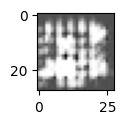

4/4 [==============================] - 0s 67ms/step
3400 [D loss: 0.001348, acc.: 100.00%] [G loss: 0.267926]
1/1 [==============================] - 0s 51ms/step


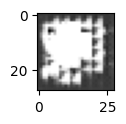

4/4 [==============================] - 0s 66ms/step
3600 [D loss: 0.023732, acc.: 99.61%] [G loss: 7.722807]
1/1 [==============================] - 0s 59ms/step


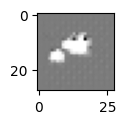

4/4 [==============================] - 0s 63ms/step
3800 [D loss: 0.006475, acc.: 99.61%] [G loss: 6.634055]
1/1 [==============================] - 0s 50ms/step


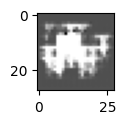

4/4 [==============================] - 0s 70ms/step
4000 [D loss: 0.000294, acc.: 100.00%] [G loss: 0.138953]
1/1 [==============================] - 0s 46ms/step


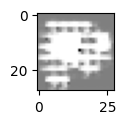

4/4 [==============================] - 0s 67ms/step
4200 [D loss: 0.002432, acc.: 100.00%] [G loss: 0.109651]
1/1 [==============================] - 0s 52ms/step


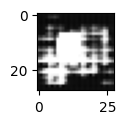

4/4 [==============================] - 0s 63ms/step
4400 [D loss: 0.007087, acc.: 99.61%] [G loss: 7.230443]
1/1 [==============================] - 0s 52ms/step


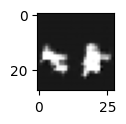

4/4 [==============================] - 0s 65ms/step
4600 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.017547]
1/1 [==============================] - 0s 93ms/step


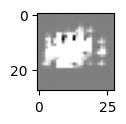

4/4 [==============================] - 0s 64ms/step
4800 [D loss: 0.000296, acc.: 100.00%] [G loss: 3.422891]
1/1 [==============================] - 0s 50ms/step


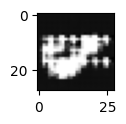

4/4 [==============================] - 0s 98ms/step
5000 [D loss: 0.003357, acc.: 100.00%] [G loss: 6.244534]
1/1 [==============================] - 0s 53ms/step


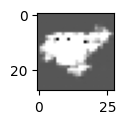

In [ ]:
# Set hyperparameters
iterations = 5000
batch_size = 128
sample_interval = 200

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

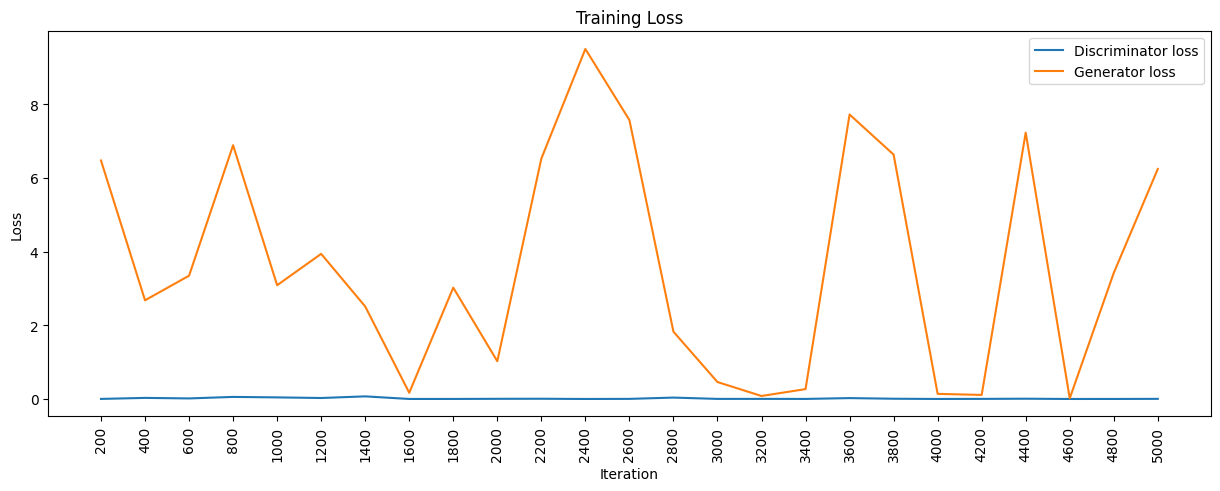

In [ ]:
losses = np.array(losses)

# Graficamos el loss de tanto el discriminador como del generador
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

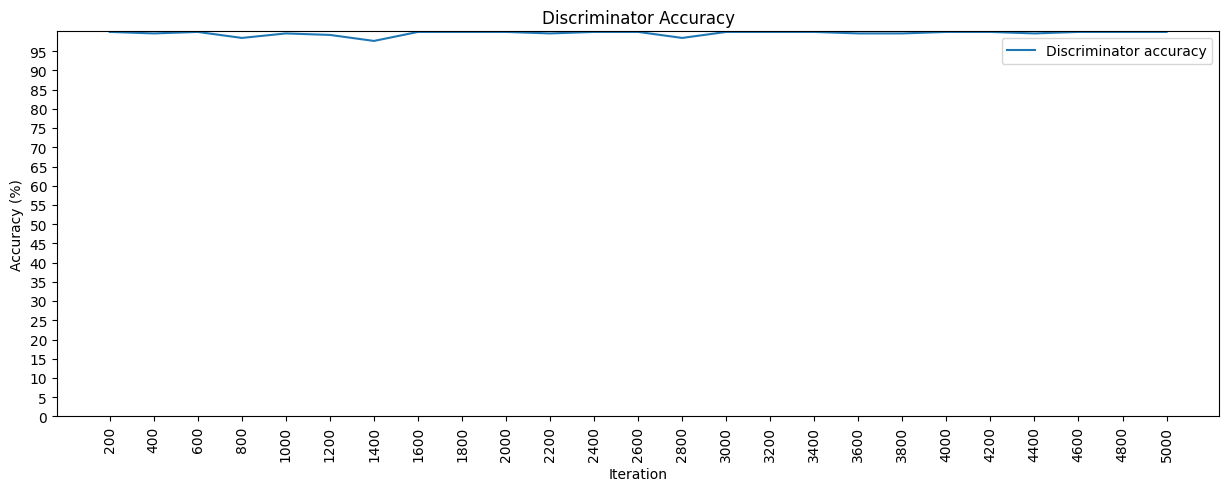

In [ ]:
accuracies = np.array(accuracies)

# Graficamos el accuracy del discriminador
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

1/1 [==============================] - 0s 61ms/step


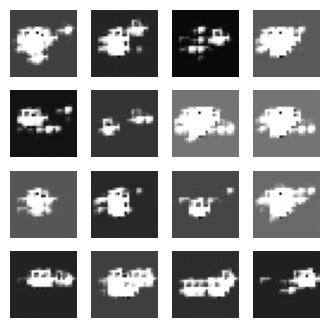

In [ ]:
sample_images(generator)

# Conclusiones - Dataset #1 - DOG:
Según los resultados obtenidos, se evidencia unas imagenes generadas aún con bastantes defectos frente al conjunto inicial de información.
Seguramente con más recursos de cómputo y tiempo, se obtendrían mejores resultados para el proceso de entrenamiento del discriminador y el generator.

# Segundo dataset - Angel

## Helpers

## Cargar set de datos  y visualizar ejemplo

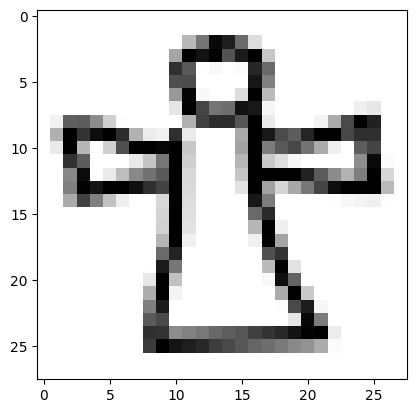

In [25]:
# Informacion viene de dataset

# Cargar el conjunto de datos Angel
input_images = "angel.npy"
data_f = np.load(input_images)

# Normalizar los valores de píxeles al rango [0, 1] para datos de entrada
x_train_f = data_f.astype('float32') / 255.0

# Redimensionar los datos de entrada para que tengan la forma adecuada para el modelo GAN
x_train_f = np.reshape(x_train_f, (x_train_f.shape[0], 28, 28, 1))

data_f=x_train_f

# Visualizar una imagen de ejemplo
plt.imshow(x_train_f[200,:,:,0], cmap='Greys')
plt.show()


In [26]:
# Obtener las dimensiones de las imágenes
img_w_f, img_h_f = x_train_f.shape[1:3]

# Mostrar las dimensiones
print("Dimensiones de las imágenes:")
print("Ancho:", img_w_f)
print("Alto:", img_h_f)


Dimensiones de las imágenes:
Ancho: 28
Alto: 28


## Construir modelo

In [27]:
def build_fas_generator(z_dim):
    model_f = Sequential()

    model_f.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model_f.add(Reshape((7, 7, 256)))
    model_f.add(BatchNormalization())
    model_f.add(LeakyReLU(alpha=0.01))

    model_f.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model_f.add(BatchNormalization())
    model_f.add(LeakyReLU(alpha=0.01))

    model_f.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model_f.add(BatchNormalization())
    model_f.add(LeakyReLU(alpha=0.01))

    model_f.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))

    return model_f

In [28]:
def build_fas_discriminator(img_shape):
    model_f = Sequential()

    model_f.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model_f.add(LeakyReLU(alpha=0.01))
    model_f.add(Dropout(0.4))

    model_f.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model_f.add(LeakyReLU(alpha=0.01))
    model_f.add(Dropout(0.4))

    model_f.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model_f.add(LeakyReLU(alpha=0.01))
    model_f.add(Dropout(0.4))

    model_f.add(Flatten())
    model_f.add(Dense(1, activation='sigmoid'))

    return model_f

In [29]:
def build_fas_gan(generator, discriminator):
    discriminator.trainable = False
    model_f = Sequential([generator, discriminator])
    return model_f

## Construcción del Modelo


In [30]:
# Se escoge un canal y un espacio latente de dimension 100
channels_f = 1
img_shape_f = (img_w_f, img_h_f, channels_f)
z_dim = 100

In [31]:
discriminator_f = build_fas_discriminator(img_shape_f)
discriminator_f.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

In [32]:
generator_f = build_fas_generator(z_dim)

In [33]:
gan_f = build_fas_gan(generator_f, discriminator_f)
gan_f.compile(loss='binary_crossentropy', optimizer=Adam())

In [34]:
generator_f.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1266944   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 128)       295040    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 128)      

In [35]:
noise_vector_f = np.random.normal(size=(z_dim,1))
noise_image_f = generator_f.predict(noise_vector_f.T)

1/1 [==============================] - 0s 161ms/step


Dimensiones antes de implementar squeeze: (1, 28, 28, 1)
Dimensiones despues de implementar squeeze: (28, 28)




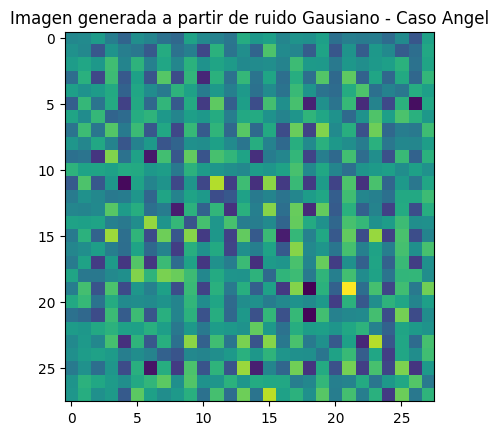

In [36]:
# Vemos una imagen de ejemplo generada a partir del ruido

print(f'Dimensiones antes de implementar squeeze: {noise_image_f.shape}')
print(f'Dimensiones despues de implementar squeeze: {noise_image_f.squeeze().shape}')
print('\n')
plt.imshow(noise_image_f.squeeze())
plt.title('Imagen generada a partir de ruido Gausiano - Caso Angel')
plt.show()

## Entrenamiento de Modelo:

In [45]:
losses_f = []
accuracies_f = []
iteration_checkpoints_f = []

def train_f(iterations_f, batch_size_f, sample_interval_f):
    real = np.ones((batch_size_f, 1))

    fake = np.zeros((batch_size_f, 1))

    for iteration in range(iterations_f):

        # -------------------------
        #  Entrenar discriminator
        # -------------------------
        idx = np.random.randint(0, data_f.shape[0], batch_size_f)
        imgs_f = data_f[idx]

        z = np.random.uniform(-1.0, 1.0, size=[batch_size_f, z_dim])
        gen_imgs_f = generator_f.predict(z)

        d_loss_real = discriminator_f.train_on_batch(imgs_f, real)
        d_loss_fake = discriminator_f.train_on_batch(gen_imgs_f, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Entrenar generator
        # ---------------------
        z = np.random.uniform(-1.0, 1.0, size=[batch_size_f, z_dim])
        gen_imgs_f = generator_f.predict(z)

        g_loss_f = gan_f.train_on_batch(z, real)

        if (iteration + 1) % sample_interval_f == 0:
            losses_f.append((d_loss, g_loss_f))
            accuracies_f.append(100.0 * accuracy)
            iteration_checkpoints_f.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss_f))

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])

            gen_imgs_f = generator_f.predict(noise)
            plt.figure(figsize=(1, 1))
            plt.imshow(gen_imgs_f[1, :, :, 0], cmap='gray')
            plt.show()

4/4 [==============================] - 0s 77ms/step
100 [D loss: 0.000074, acc.: 100.00%] [G loss: 17.635155]
1/1 [==============================] - 0s 63ms/step


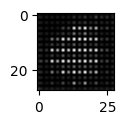

4/4 [==============================] - 0s 75ms/step
200 [D loss: 0.000001, acc.: 100.00%] [G loss: 21.098888]
1/1 [==============================] - 0s 56ms/step


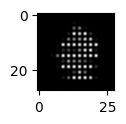

4/4 [==============================] - 0s 113ms/step
300 [D loss: 0.000000, acc.: 100.00%] [G loss: 19.724539]
1/1 [==============================] - 0s 61ms/step


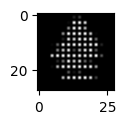

4/4 [==============================] - 0s 83ms/step
400 [D loss: 0.000000, acc.: 100.00%] [G loss: 20.502188]
1/1 [==============================] - 0s 62ms/step


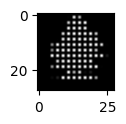

4/4 [==============================] - 0s 81ms/step
500 [D loss: 0.000004, acc.: 100.00%] [G loss: 21.685303]
1/1 [==============================] - 0s 58ms/step


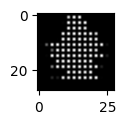

4/4 [==============================] - 0s 80ms/step
600 [D loss: 0.000000, acc.: 100.00%] [G loss: 22.609489]
1/1 [==============================] - 0s 58ms/step


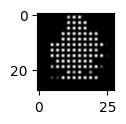

4/4 [==============================] - 0s 77ms/step
700 [D loss: 0.000001, acc.: 100.00%] [G loss: 22.134365]
1/1 [==============================] - 0s 56ms/step


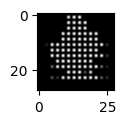

4/4 [==============================] - 0s 82ms/step
800 [D loss: 0.000001, acc.: 100.00%] [G loss: 22.881607]
1/1 [==============================] - 0s 59ms/step


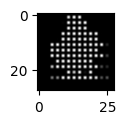

4/4 [==============================] - 0s 82ms/step
900 [D loss: 0.000000, acc.: 100.00%] [G loss: 21.237417]
1/1 [==============================] - 0s 57ms/step


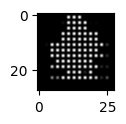

4/4 [==============================] - 0s 82ms/step
1000 [D loss: 0.000000, acc.: 100.00%] [G loss: 22.662477]
1/1 [==============================] - 0s 56ms/step


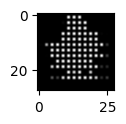

4/4 [==============================] - 0s 79ms/step
1100 [D loss: 0.027902, acc.: 99.22%] [G loss: 0.426889]
1/1 [==============================] - 0s 73ms/step


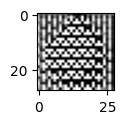

4/4 [==============================] - 0s 81ms/step
1200 [D loss: 0.041855, acc.: 99.22%] [G loss: 5.024960]
1/1 [==============================] - 0s 88ms/step


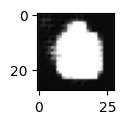

4/4 [==============================] - 0s 89ms/step
1300 [D loss: 0.017815, acc.: 99.22%] [G loss: 7.311790]
1/1 [==============================] - 0s 111ms/step


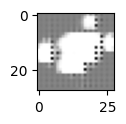

4/4 [==============================] - 0s 81ms/step
1400 [D loss: 0.026290, acc.: 99.61%] [G loss: 0.303604]
1/1 [==============================] - 0s 64ms/step


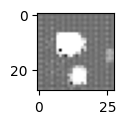

4/4 [==============================] - 0s 80ms/step
1500 [D loss: 0.017332, acc.: 99.61%] [G loss: 0.080538]
1/1 [==============================] - 0s 60ms/step


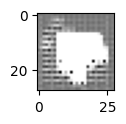

4/4 [==============================] - 0s 83ms/step
1600 [D loss: 0.006222, acc.: 100.00%] [G loss: 0.183371]
1/1 [==============================] - 0s 61ms/step


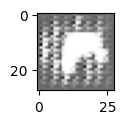

4/4 [==============================] - 0s 81ms/step
1700 [D loss: 0.007006, acc.: 100.00%] [G loss: 9.159106]
1/1 [==============================] - 0s 63ms/step


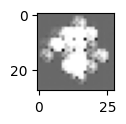

4/4 [==============================] - 0s 85ms/step
1800 [D loss: 0.007149, acc.: 100.00%] [G loss: 4.806006]
1/1 [==============================] - 0s 63ms/step


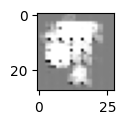

4/4 [==============================] - 0s 83ms/step
1900 [D loss: 0.006737, acc.: 99.61%] [G loss: 5.670238]
1/1 [==============================] - 0s 60ms/step


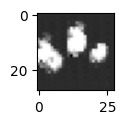

4/4 [==============================] - 0s 86ms/step
2000 [D loss: 0.014735, acc.: 99.61%] [G loss: 1.632338]
1/1 [==============================] - 0s 66ms/step


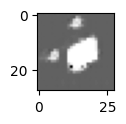

4/4 [==============================] - 0s 81ms/step
2100 [D loss: 0.013070, acc.: 99.61%] [G loss: 0.495054]
1/1 [==============================] - 0s 57ms/step


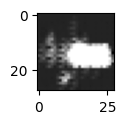

4/4 [==============================] - 0s 86ms/step
2200 [D loss: 0.020596, acc.: 99.61%] [G loss: 16.887794]
1/1 [==============================] - 0s 56ms/step


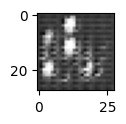

4/4 [==============================] - 0s 81ms/step
2300 [D loss: 0.000342, acc.: 100.00%] [G loss: 0.283316]
1/1 [==============================] - 0s 67ms/step


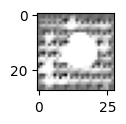

4/4 [==============================] - 0s 121ms/step
2400 [D loss: 0.000144, acc.: 100.00%] [G loss: 0.065648]
1/1 [==============================] - 0s 60ms/step


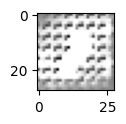

4/4 [==============================] - 0s 84ms/step
2500 [D loss: 0.000709, acc.: 100.00%] [G loss: 2.376387]
1/1 [==============================] - 0s 69ms/step


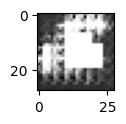

4/4 [==============================] - 0s 100ms/step
2600 [D loss: 0.021499, acc.: 99.22%] [G loss: 5.511930]
1/1 [==============================] - 0s 62ms/step


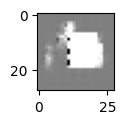

4/4 [==============================] - 0s 94ms/step
2700 [D loss: 0.011298, acc.: 99.61%] [G loss: 10.577190]
1/1 [==============================] - 0s 64ms/step


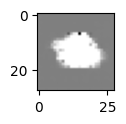

4/4 [==============================] - 0s 84ms/step
2800 [D loss: 0.007184, acc.: 100.00%] [G loss: 6.295097]
1/1 [==============================] - 0s 68ms/step


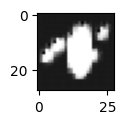

4/4 [==============================] - 1s 138ms/step
2900 [D loss: 0.025372, acc.: 99.22%] [G loss: 5.549484]
1/1 [==============================] - 0s 76ms/step


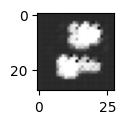

4/4 [==============================] - 0s 100ms/step
3000 [D loss: 0.025629, acc.: 99.22%] [G loss: 2.371742]
1/1 [==============================] - 0s 112ms/step


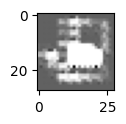

In [46]:
# Set hyperparameters

# iterations_f = 10
# batch_size_f = 32
# sample_interval_f = 10

iterations_f = 3000
batch_size_f = 128
sample_interval_f = 100


# Train the DCGAN for the specified number of iterations
train_f(iterations_f, batch_size_f, sample_interval_f)

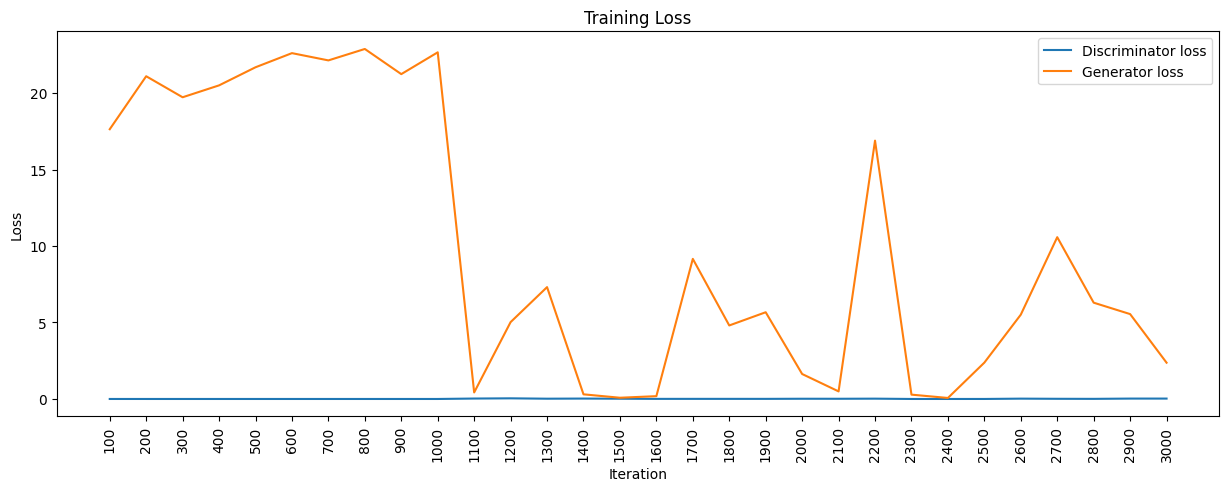

In [47]:
losses_f = np.array(losses_f)

# Graficamos el loss de tanto el discriminador como del generador
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints_f, losses_f.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints_f, losses_f.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints_f, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

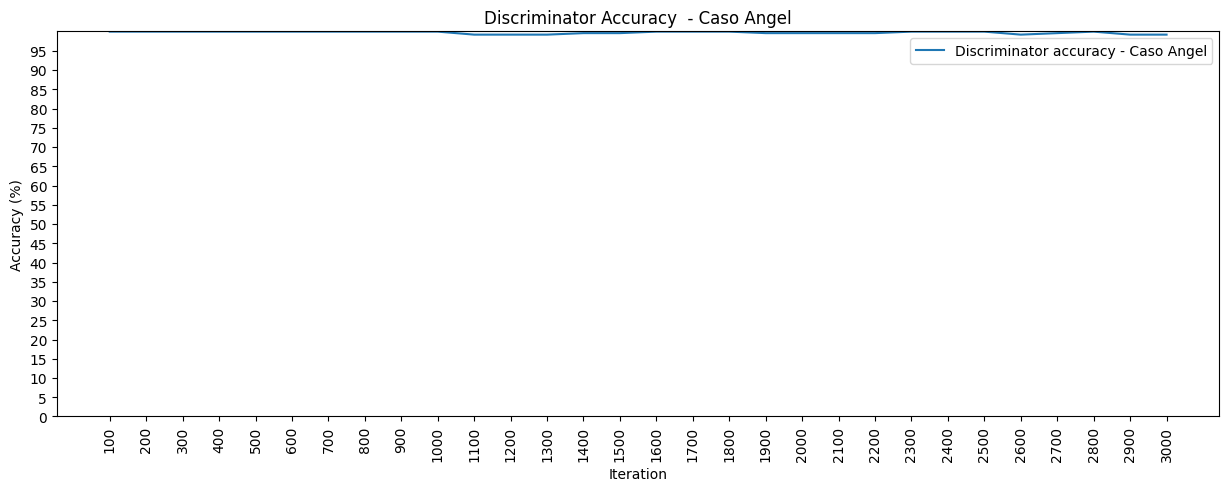

In [48]:
accuracies_f = np.array(accuracies_f)

# Graficamos el accuracy del discriminador
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints_f, accuracies_f, label="Discriminator accuracy - Caso Angel")

plt.xticks(iteration_checkpoints_f, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy  - Caso Angel")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

1/1 [==============================] - 0s 114ms/step


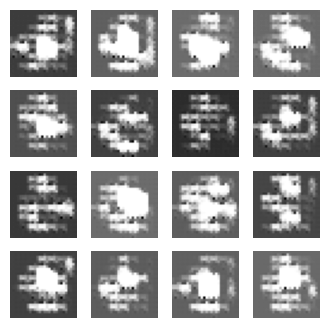

In [49]:
sample_images(generator_f)

# Conclusiones - Dataset #2 - Angel:
Según los resultados obtenidos, se evidencia unas imagenes generadas aún con bastantes defectos frente al conjunto inicial de información.
Seguramente con más recursos de cómputo y tiempo, se obtendrían mejores resultados para el proceso de entrenamiento del discriminador y el generator.